# Data Preparation

In [9]:
import pandas as pd
import numpy as np
import sys

sys.path.append("/home/jovyan/work")

train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')
print(train_data.shape)
print(test_data.shape)

(8000, 22)
(3799, 21)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(train_data.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(8000, 22)
(5120, 19)
(1280, 19)
(1600, 19)


## Experiment 1: XGBoost 

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, random_state=0)

In [33]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

thr=0.8
pred = clf.predict_proba(X_val)[:,1]
predx = [x for x in pred > thr]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_val, pred),3)}')

print(confusion_matrix(y_val, predx))
print(recall_score(y_val, predx))
print(accuracy_score(y_val, predx))
print(balanced_accuracy_score(y_val, predx))
print(f1_score(y_val, predx))

1003 out of 1280 or 78% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.715
[[ 89 114]
 [188 889]]
0.8254410399257196
0.7640625
0.6319323426229584
0.8548076923076924


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.715


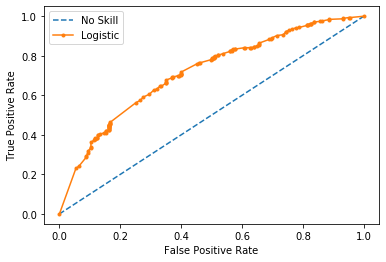

In [34]:
from src.visualization.visualize import plot_roc_curve
plot_roc_curve(pred, y_val)

In [29]:
thr=0.8
pred = clf.predict_proba(X_test)[:,1]
predx = [x for x in pred > thr]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, pred),3)}')

print(confusion_matrix(y_test, predx))
print(recall_score(y_test, predx))
print(accuracy_score(y_test, predx))
print(balanced_accuracy_score(y_test, predx))
print(f1_score(y_test, predx))

1150 out of 1600 or 72% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.71
[[ 136  127]
 [ 314 1023]]
0.7651458489154824
0.724375
0.6411280575375891
0.8226779252110977


## Experiment 2: XGBoost with Random Search CV

In [12]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=42)
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, random_state=42)

In [19]:
param_grid = {
        'max_depth': [3, 6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'n_estimators': [50, 100, 200]}

In [20]:
from sklearn.model_selection import RandomizedSearchCV
xgb_rcv = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='roc_auc')
xgb_rcv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.6422271  0.65042826 0.61411328 0.64465607 0.48186017 0.56988718
 0.62046284        nan 0.63418352        nan 0.69131929 0.68363911
        nan 0.64027088 0.67416368 0.66811843 0.51618429 0.69136956
 0.59804786 0.65344274        nan 0.68845289 0.6332842  0.56284616
 0.53131916 0.69142661 0.67759793 0.65425783 0.68834625 0.63307364
        nan 0.65108305 0.63711241 0.54712035 0.65914565 0.49058367
        nan 0.64967295 0.67192762 0.65525631 0.64522391 0.51618565
 0.66802062 0.49776326 0.55936029 0.6509866         nan        nan
 0.62518424 0.68513887 0.64760669 0.49927389 0.49442682 0.69157944
 0.4847354  0.64449305 0.69171936        nan        nan 0.65851939
 0.65433934 0.63710018 0.63325567 0.5120348  0.64836065 0.51605592
 0.51852768        nan 0.66381068 0.66399272 0.65276485 0.57661439
 0.63959164 0.64820171 0.65050434 0.64832805 0.64990932 0

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                        max_depth=1,
                                                        random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0, 3],
                                        'max_depth': [3, 6, 10, 15, 20],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

{'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
935 out of 1280 or 73% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.722
[[101 102]
 [244 833]]
0.7734447539461468
0.7296875
0.6354908498794773
0.8280318091451293
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.722


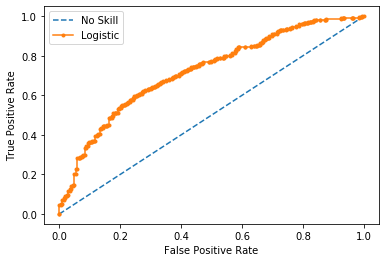

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

thr = 0.8
pred = xgb_rcv.predict_proba(X_val)[:,1]
predx = [x for x in pred > thr]
print(xgb_rcv.best_params_)
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_val, pred),3)}')

print(confusion_matrix(y_val, predx))
print(recall_score(y_val, predx))
print(accuracy_score(y_val, predx))
print(balanced_accuracy_score(y_val, predx))
print(f1_score(y_val, predx))
plot_roc_curve(pred, y_val)

In [42]:
submission = xgb_rcv.predict_proba(test_data_x)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("../data/submission/0203_xgb_pred.csv", index=False)